# Heavy User Attributes - No Search Counts

What is the frequency and percentage of heavy users in 1 day for:
* Tab Count
* Window Count
* Active Addons Count
* Session Started on this Day
* Normalized Channel
* OS
* Is Default Browser
* Country
* Locale
* Default Search Engine

In [3]:
import pyspark.sql.functions as F
import pyspark.sql.types as st
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

###Prepare Data

In [5]:
#Global variables
sample_id = 42
week_1_start = '20180920'
week_1_end = '20180926'
wday = '20180926'
wday_cond = "submission_date_s3 = \'" +  wday + "\'"
heavy_uri = '169'
heavy_ah = '0.93'

In [6]:
# From telemetry docs for how clients_daily deteremines values
sum_query = """
    SELECT 
      client_id,
      submission_date_s3,
      sum(coalesce(scalar_parent_browser_engagement_total_uri_count, 0)) AS td_uri,
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)) AS td_active_ticks,      
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)*5/3600) AS td_active_hours,
      sum(subsession_length/3600) AS td_subsession_hours,   
      sum(CASE WHEN subsession_counter = 1 THEN 1 ELSE 0 END) AS sessions_started_on_this_day,
      mean(active_addons_count) AS active_addons_count_mean,
      max(scalar_parent_browser_engagement_max_concurrent_tab_count) AS tab_count_max,
      max(scalar_parent_browser_engagement_max_concurrent_window_count) AS window_count_max,
      max(scalar_parent_browser_engagement_unique_domains_count) AS domains_count_max,
      first(profile_creation_date) AS profile_creation_date,
      first(previous_build_id) AS previous_build_id,
      first(normalized_channel) AS normalized_channel,
      first(os) AS os,
      first(normalized_os_version) AS normalized_os_version,
      first(windows_build_number) AS windows_build_number,
      first(install_year) AS install_year,
      first(distribution_id) AS distribution_id,
      count(distinct document_id) AS pings_aggregated_by_this_row,
      first(app_build_id) AS app_build_id,
      first(app_display_version) AS app_display_version,
      first(update_channel) AS update_channel,
      first(update_enabled) AS update_enabled,
      first(update_auto_download) AS update_auto_download,
      first(timezone_offset) AS timezone_offset,
      first(vendor) AS vendor,
      first(is_default_browser) AS is_default_browser,
      first(default_search_engine) AS default_search_engine,
      sum(devtools_toolbox_opened_count) AS devtools_toolbox_opened_count_sum,
      mean(places_bookmarks_count) AS places_bookmarks_count_mean,
      mean(places_pages_count) AS places_pages_count_mean,
      sum(scalar_parent_browser_engagement_tab_open_event_count) AS td_tab_event_count,
      sum(scalar_parent_browser_engagement_window_open_event_count) AS td_window_event_count,
      first(CASE WHEN country IS NOT NULL AND country != '??' THEN country ELSE NULL END) as country,
      first(CASE WHEN country IS NOT NULL AND country != '??' 
                THEN CASE WHEN city IS NOT NULL THEN city ELSE '??' END
                ELSE NULL END) AS city,
      first(geo_subdivision1) AS geo_subdivision1,
      first(locale) AS locale,
      first(sync_configured) AS sync_configured,
      sum(sync_count_desktop) AS sync_count_desktop,
      sum(sync_count_mobile) AS sync_count_mobile,
      first(sample_id) AS sample_id
    FROM main_summary
    WHERE 
      app_name='Firefox'
      AND submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
    GROUP BY
        1, 2
    """

search_query = """
  SELECT client_id,
         submission_date_s3,
         engine,
         SUM(sap) as sap,
         SUM(tagged_sap) as tagged_sap,
         SUM(tagged_follow_on) as tagged_follow_on,
         SUM(organic) as in_content_organic
  FROM search_clients_daily
  WHERE
      submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
  GROUP BY
      1, 2, 3
    """

In [7]:
ms_1week_sum = spark.sql(sum_query.format(week_1_start,week_1_end,sample_id))
search_wk = spark.sql(search_query.format(week_1_start,week_1_end,sample_id))

In [8]:
# Fill null search counts with 0s
search_wk = search_wk.na.fill(0)
# Sum over the day
search_wk_sum = search_wk.groupBy('client_id', 'submission_date_s3') \
                         .agg(F.sum(F.col('sap')+F.col('in_content_organic')))  \
                         .withColumnRenamed('sum((sap + in_content_organic))','td_search_counts') \
                         .sort('client_id', 'submission_date_s3')
# Join the search table with the other counts
ms_1week = ms_1week_sum.join(search_wk_sum, ['client_id', 'submission_date_s3'], 'full_outer').na.fill(0)
# Average the total daily values over the week
ms_1week_avg = ms_1week.groupBy('client_id').avg() \
    .withColumnRenamed('avg(td_uri)','avg_uri') \
    .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
    .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
    .withColumnRenamed('avg(td_subsession_hours)','avg_subsession_hours') \
    .withColumnRenamed('avg(sessions_started_on_this_day)','avg_sessions_started') \
    .withColumnRenamed('avg(active_addons_count_mean)','avg_addons_count') \
    .withColumnRenamed('avg(tab_count_max)','avg_tab_count') \
    .withColumnRenamed('avg(window_count_max)','avg_window_count') \
    .withColumnRenamed('avg(domains_count_max)','avg_domains_count') \
    .withColumnRenamed('avg(pings_aggregated_by_this_row)', 'avg_pings') \
    .withColumnRenamed('avg(sync_count_desktop)', 'avg_sync_desktop') \
    .withColumnRenamed('avg(sync_count_mobile)', 'avg_sync_mobile') \
    .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')

In [9]:
ms_wday = ms_1week.where(wday_cond)

### Attributes of Heavy Users

In [11]:
def get_freq_arrays(heavy_cutoff, heavy_column_name, attr_column_name, gte=True, df=ms_wday):
    """
    Given a heavy cutoff, a heavy column name and an attribute column name,
    returns two arrays for a frequency graph.
    
    Params:
    heavy_cutoff (number): a cutoff to define a heavy user
    heavy_column_name (string): name of the column for heavy user
    attr_column_name (string): name of the column for the attribute we're interested in
    gte (boolean, default True): True if >= cutoff, False if < cutoff
    df (dataframe, default ms_wday): dataframe to calculate frequency arrays from
    
    Returns two arrays for graphing: attribute count array and number of clients array
    """

#   get one day of data for heavy or non-heavy users
    eval = '>=' if gte else '<'
    hu = df.where(heavy_column_name + eval + heavy_cutoff)

#   get frequencies of attribute column
    freq_hu = hu.groupby(attr_column_name) \
        .agg(F.countDistinct('client_id')).withColumnRenamed('count(DISTINCT client_id)', 'num_clients') \
        .sort(attr_column_name) \
        .filter(F.col(attr_column_name).isNotNull())

#   get 2 arrays for attribute column count and number of clients
    attr_count_arr = array(freq_hu.select(attr_column_name).rdd.flatMap(lambda x:x).collect())
    num_clients_arr = array(freq_hu.select('num_clients').rdd.flatMap(lambda x: x).collect())

    if gte:
        print 'max heavy num clients:', num_clients_arr.max()
    return attr_count_arr, num_clients_arr
  
  
def get_list_freq_arrays(attr_column_name, df=ms_wday):
    """
    Given an attribute column name,
    return list of twelve arrays for a frequency graph - 
        uri attribute count and number of clients for heavy users,
        uri attribute count and number of clients for non-heavy users,
        search count attribute count and number of clients for heavy users,
        search count attribute count and number of clients for non-heavy users,
        active hours attribute count and number of clients for heavy users,
        active hours attribute count and number of clients for non-heavy users.
    
    Params:
    attr_column_name (string): name of the column for the attribute we're interested in
    df (dataframe, default ms_wday): dataframe to calculate frequency arrays from
    
    Returns list of twelve arrays for graphing: uri attribute count array and number of clients array for heavy,
                                     uri attribute count array and number of clients array for non-heavy,
                                     search count attribute count array and number of clients array for heavy,
                                     search count attribute count array and number of clients array for non-heavy,
                                     active hours attribute array and number of clients array for heavy,
                                     active hours attribute array and number of clients array for non-heavy
    """
    
    arrlist = []
    huri_attr_arr, huri_attr_c_arr = get_freq_arrays(heavy_uri, 'td_uri', attr_column_name, True, df)
    arrlist.append(huri_attr_arr)
    arrlist.append(huri_attr_c_arr)
    nhuri_attr_arr, nhuri_attr_c_arr = get_freq_arrays(heavy_uri, 'td_uri', attr_column_name, False, df)
    arrlist.append(nhuri_attr_arr)
    arrlist.append(nhuri_attr_c_arr)
#    hsc_attr_arr, hsc_attr_c_arr = get_freq_arrays(heavy_sc, 'td_search_counts', attr_column_name, True, df)
#    arrlist.append(hsc_attr_arr)
#    arrlist.append(hsc_attr_c_arr)
#    nhsc_attr_arr, nhsc_attr_c_arr = get_freq_arrays(heavy_sc, 'td_search_counts', attr_column_name, False, df)
#    arrlist.append(nhsc_attr_arr)
#    arrlist.append(nhsc_attr_c_arr)
    hah_attr_arr, hah_attr_c_arr = get_freq_arrays(heavy_ah, 'td_active_hours', attr_column_name, True, df)
    arrlist.append(hah_attr_arr)
    arrlist.append(hah_attr_c_arr)
    nhah_attr_arr, nhah_attr_c_arr = get_freq_arrays(heavy_ah, 'td_active_hours', attr_column_name, False, df)
    arrlist.append(nhah_attr_arr)
    arrlist.append(nhah_attr_c_arr)
    
    return arrlist

In [12]:
def calc_plot_heavy_bars(ax, heavy_cutoff, heavy_column_name, attr_column_name, xlabel, xulim, yulim, title, width=0.4, xllim=0, yllim=0, conv_xaxis=False, pct_label=True, xlabel_ra=False):
    """
    Given a heavy cutoff, a heavy column name and an attribute column name, prepare a bar chart graph.
    
    Params:
    ax (axis): axis for the plot
    heavy_cutoff (number): a cutoff to define a heavy user
    heavy_column_name (string): name of the column for heavy user
    attr_column_name (string): name of the column for the attribute we're interested in
    xlabel (string): x-axis label
    xlim (number): limit for x-axis
    ylim (number): limit for y-axis
    title (string): title for the plot    
    width (number): width of bars (default 0.4)
    xllim (number): lower limit for x-axis (default 0)
    yllim (nuumber): lower limit for y-axis (default 0)
    conv_xaxis (boolean): convert the x-axis arrays to number (default False)
    pct_label (boolean): add the percent label on top of the bar (default True)
    xlabel_ra (boolean): align the xlabel to the right, for long labels (default False)
    """
    
    h_attr_arr, h_clients_arr = get_freq_arrays(heavy_cutoff, heavy_column_name, attr_column_name)
    nh_attr_arr, nh_clients_arr = get_freq_arrays(heavy_cutoff, heavy_column_name, attr_column_name, False)

    plot_heavy_bars(ax, h_attr_arr, h_clients_arr, nh_attr_arr, nh_clients_arr, 
                    xlabel, xulim, yulim, title, width, xllim, yllim, 
                    conv_xaxis, pct_label, xlabel_ra)
      
    return None

In [13]:
def plot_heavy_bars(ax, h_attr_arr, h_clients_arr, nh_attr_arr, nh_clients_arr,
                    xlabel, xulim, yulim, title, width=0.4, xllim=0, yllim=0,
                    conv_xaxis=False, pct_label=True, xlabel_ra=False):
    """
    Given an axis, list of 12 arrays and graph variables, prepare a bar chart graph.
    
    Params:
    ax (axis): axis for the plot
    h_attr_arr (array): heavy attribute array
    h_clients_arr (array): heavy number of clients array
    nh_attr_arr (array): non-heavy attribute array
    nh_clients_arr (array): non-heavy number of clients array
    xlabel (string): x-axis label
    xulim (number): upper limit for x-axis
    yulim (number): upper limit for y-axis
    title (string): title for the plot    
    width (number): width of bars (default 0.4)
    xllim (number): lower limit for x-axis (default 0)
    yllim (number): lower limit for y-axis (default 0)
    conv_xaxis (boolean): convert the x-axis arrays to number (default False)
    pct_label (boolean): add the percent label on top of the bar (default True)
    xlabel_ra (boolean): align the xlabel to the right, for long labels (default False)
    """
    
    if (conv_xaxis):
        xllim = 1
        if (len(h_attr_arr) != len(nh_attr_arr)):
            print 'Mismatch in xarray lengths!'
            extras =  np.setxor1d(h_attr_arr, nh_attr_arr)
            for item in extras:
                print item
                if item in nh_attr_arr:    # extra item in non-heavy array
                    nhidx = nh_attr_arr.tolist().index(item)
                    print 'Delete ' + item + ' from non-heavy array'
                    nh_attr_arr = np.delete(nh_attr_arr, nhidx)
                    nh_clients_arr = np.delete(nh_clients_arr, nhidx)
                else:    # extra item in heavy array
                    hidx = h_attr_arr.tolist().index(item)
                    print ('Insert ' + item + ' into non-heavy array')
                    nh_attr_arr = np.insert(nh_attr_arr, hidx, item)
                    nh_clients_arr = np.insert(nh_clients_arr, hidx, 0)

        xticks = array(list(range(1, len(h_attr_arr)+1)))
        ax.set_xticks(xticks)
        if (xlabel_ra):
            ax.set_xticklabels(h_attr_arr, rotation=45, ha='right')
        else:
            ax.set_xticklabels(h_attr_arr, rotation=45)
        h_attr_arr = xticks
        nh_attr_arr = xticks

    # the bar chart
    nhbars = ax.bar(nh_attr_arr - width/2, nh_clients_arr, width, 
                    label ='Non Heavy', color = 'lightsalmon')
    hbars = ax.bar(h_attr_arr + width/2, h_clients_arr, width, 
                   label ='Heavy', color = 'mediumaquamarine')
    ax.set_xlabel(xlabel)
    ax.set_xlim(xllim-1, xulim)
    ax.set_ylabel('Number of Clients')
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)  
    ax.set_ylim(yllim, yulim)
    ax.set_title(title)
    ax.legend(loc='best')
    yrange = yulim - yllim
  
    if (pct_label):
        # Add percent labels above the heavy bars
        for hrect,nhrect in zip(hbars,nhbars):
            xloc = hrect.get_x()
            if (xloc >= xllim and xloc <= (xulim - 1)):
                hheight = hrect.get_height()
                nhheight = nhrect.get_height()
                htext = hheight*1.0/(hheight + nhheight)*100
                ax.text(xloc + hrect.get_width()/2.0, hheight+.01*yrange, '{0:,.2f}%'.format(htext), 
                        ha='center', va='bottom', rotation='vertical', fontsize=8)

    return None

def plot_three_heavy_bars(arrlist, fig_size, xlabel, title, xulim, yulim, 
                          width=0.4, xllim=0, yllim=0, conv_xaxis=False, 
                          pct_label=True, xlabel_ra=False, rows=True):
    """
    Given list of twelve arrays and some graph parameters, prepare a graph with 3 bar charts.
    
    Params:
    arrlist (list of arrays): list of 12 arrays to graph
        [0] heavy URI attribute array
        [1] heavy URI number of clients array
        [2] non-heavy URI attribute array
        [3] non-heavy URI number of clients array
        [4] heavy search count attribute array
        [5] heavy search count number of clients array
        [6] non-heavy search count attribute array
        [7] non-heavy search count number of clients array
        [8] heavy active hours attribute array
        [9] heavy active hours number of clients array
        [10] non-heavy active hours attribute array
        [11] non-heavy active hours number of clients array
    fig_size (tuple of integers): size of the figure
    xlabel (string): x-axis label
    xulim (number): upper limit for x-axis
    yulim (number): upper limit for y-axis
    title (string): title for the plot    
    width (number): width of bars (default 0.4)
    xllim (number): lower limit for x-axis (default 0)
    yllim (number): lower limit for y-axis (default 0)
    conv_xaxis (boolean): convert the x-axis arrays to number (default False)
    pct_label (boolean): add the percent label on top of the bar (default True)
    xlabel_ra (boolean): align the xlabel to the right, for long labels (default False)
    rows (boolean): create 3 rows if true, create 3 columns if false (default True)
    """      

    plt.gcf().clear()
    if rows:
        fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=fig_size)
    else:
        fig, (ax1, ax3) = plt.subplots(nrows=1, ncols=2, figsize=fig_size)      
    
    # the bar chart for uri
    title_uri = title + ' for URI Users'
    plot_heavy_bars(ax1, arrlist[0], arrlist[1], arrlist[2], arrlist[3], xlabel, xulim, yulim,
                    title_uri, width, xllim, yllim, conv_xaxis, pct_label, xlabel_ra)
    # the bar chart for sc
#    title_sc = title + ' for Search Count Users'
#    plot_heavy_bars(ax2, arrlist[4], arrlist[5], arrlist[6], arrlist[7], xlabel, xulim, yulim,
#                    title_sc, width, xllim, yllim, conv_xaxis, pct_label, xlabel_ra)
    # the bar chart for ah
    title_ah = title + ' for Active Hours Users'
    plot_heavy_bars(ax3, arrlist[4], arrlist[5], arrlist[6], arrlist[7], xlabel, xulim, yulim,
                    title_ah, width, xllim, yllim, conv_xaxis, pct_label, xlabel_ra)
    plt.tight_layout()
    display(fig)
  
    return None

####Tab Count

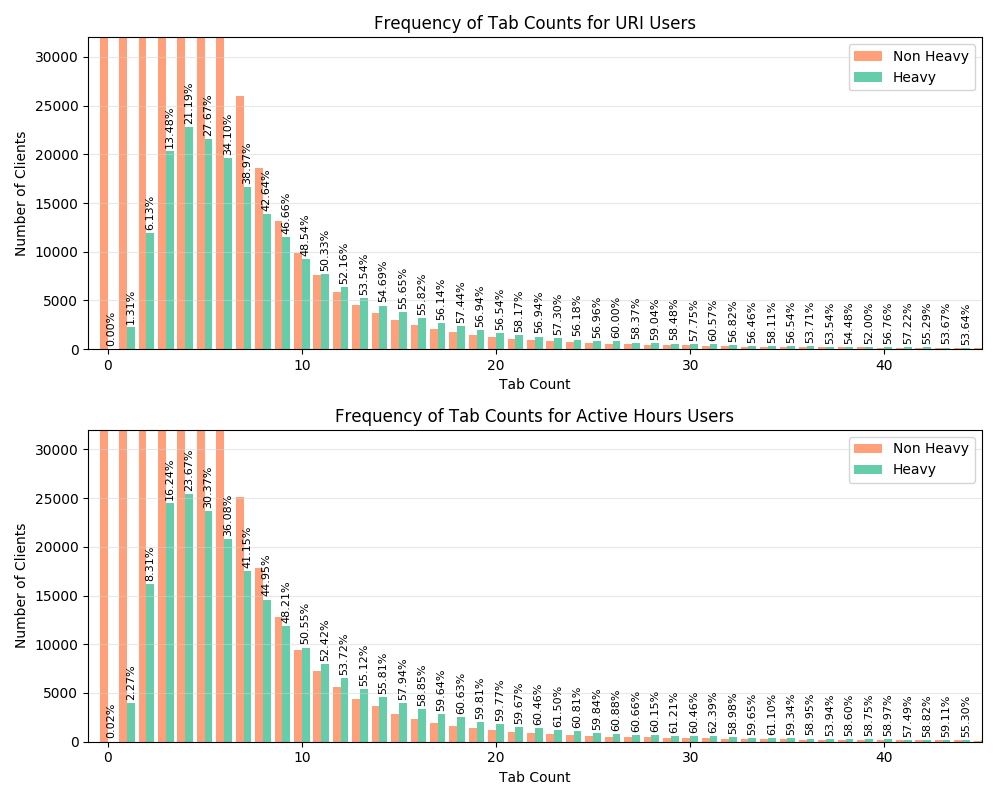

In [15]:
list_tc_plot_arrs = get_list_freq_arrays('tab_count_max')
plot_three_heavy_bars(list_tc_plot_arrs, (10,8), 'Tab Count', 'Frequency of Tab Counts', 45, 32000)

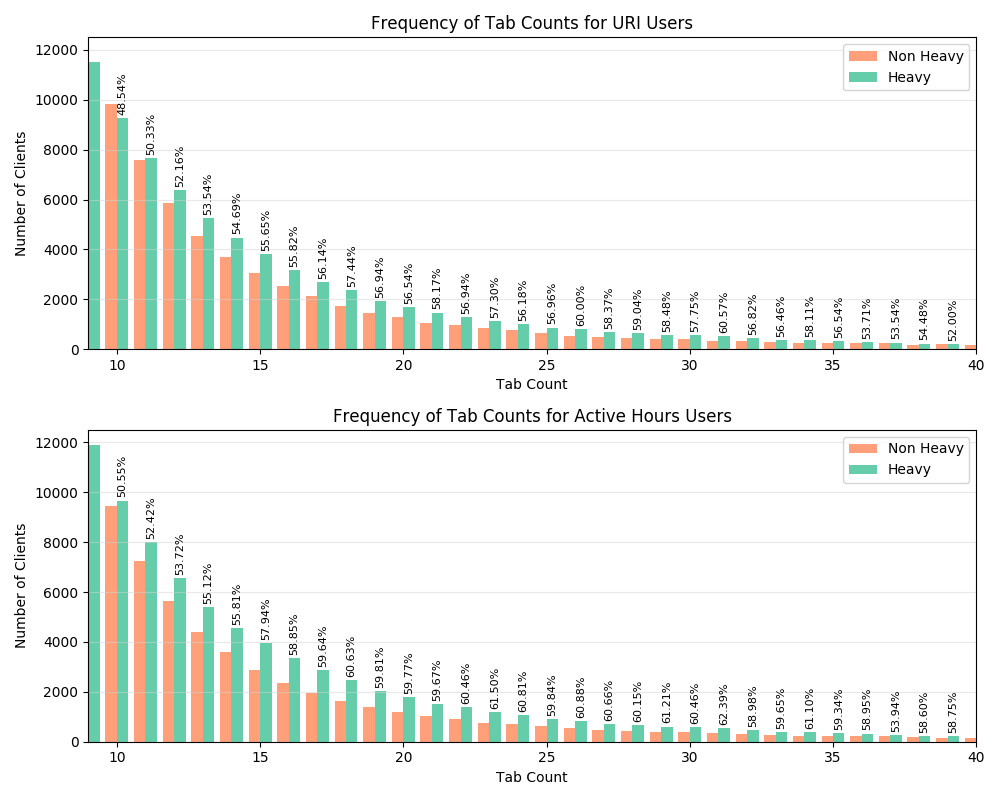

In [16]:
plot_three_heavy_bars(list_tc_plot_arrs, (10,8), 'Tab Count', 'Frequency of Tab Counts', 40, 12500, xllim=10)

####Window Count

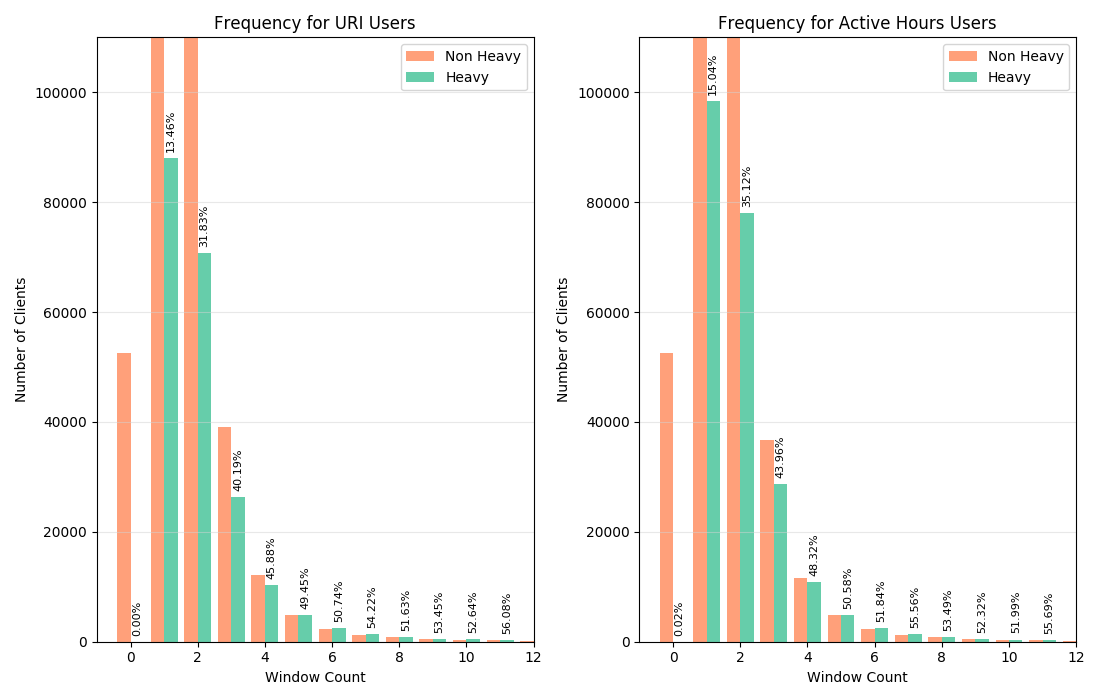

In [18]:
list_wc_plot_arrs = get_list_freq_arrays('window_count_max')
plot_three_heavy_bars(list_wc_plot_arrs, (11,7), 'Window Count', 'Frequency', 12, 110000, rows=False)

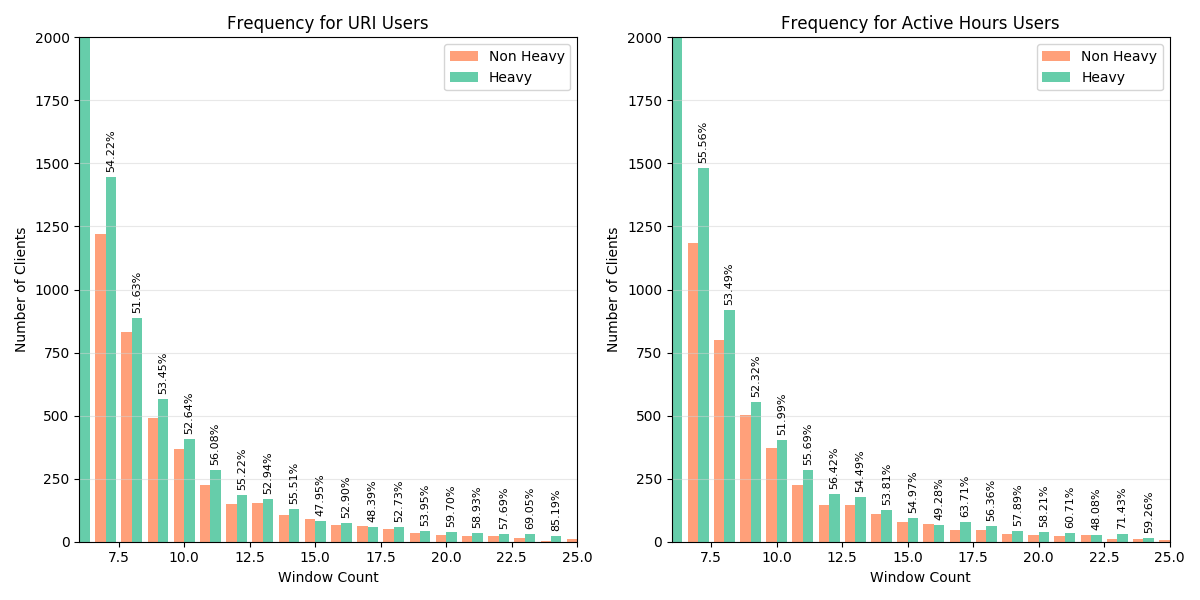

In [19]:
plot_three_heavy_bars(list_wc_plot_arrs, (12,6), 'Window Count', 'Frequency', 25, 2000, xllim=7, rows=False)

####Active Addons Count

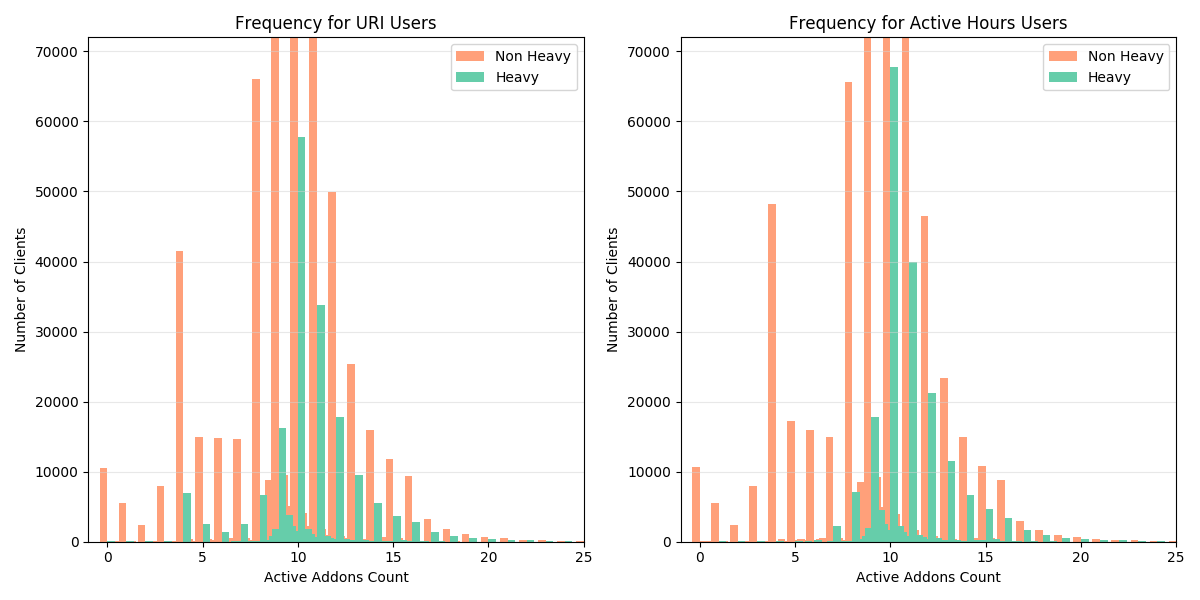

In [21]:
list_aa_plot_arrs = get_list_freq_arrays('active_addons_count_mean')
plot_three_heavy_bars(list_aa_plot_arrs, (12,6), 'Active Addons Count', 'Frequency', 25, 72000, pct_label=False, rows=False)

####Sessions Started on this Day

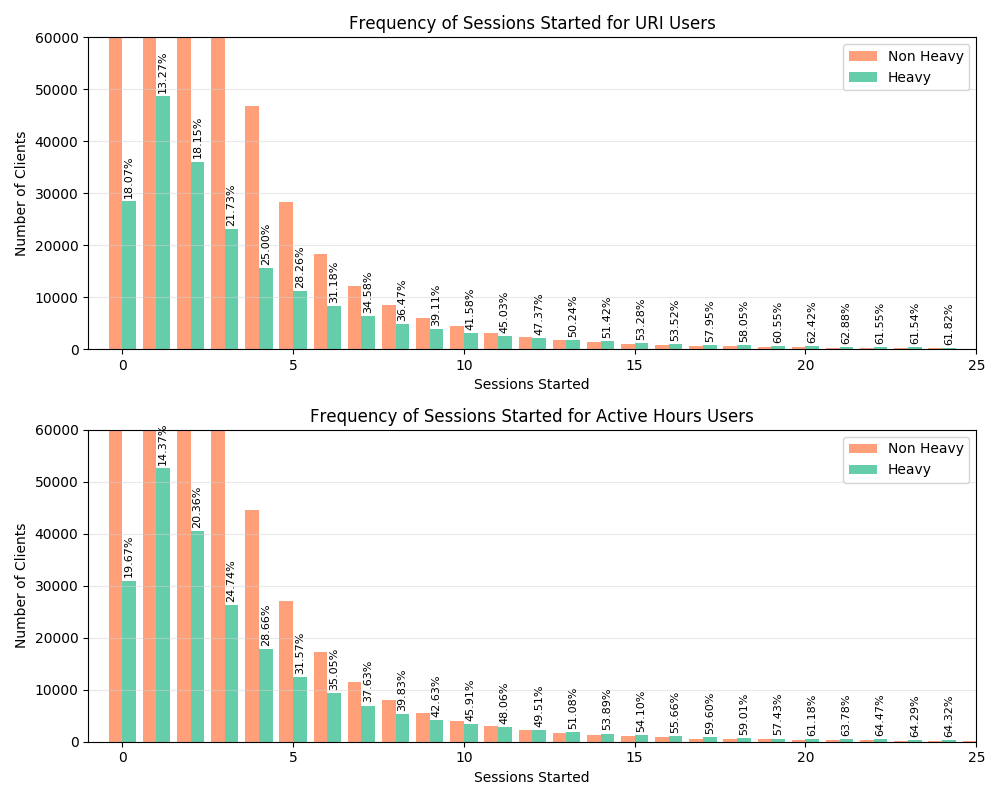

In [23]:
list_ss_plot_arrs = get_list_freq_arrays('sessions_started_on_this_day')
plot_three_heavy_bars(list_ss_plot_arrs, (10,8), 'Sessions Started', 'Frequency of Sessions Started', 25, 60000)

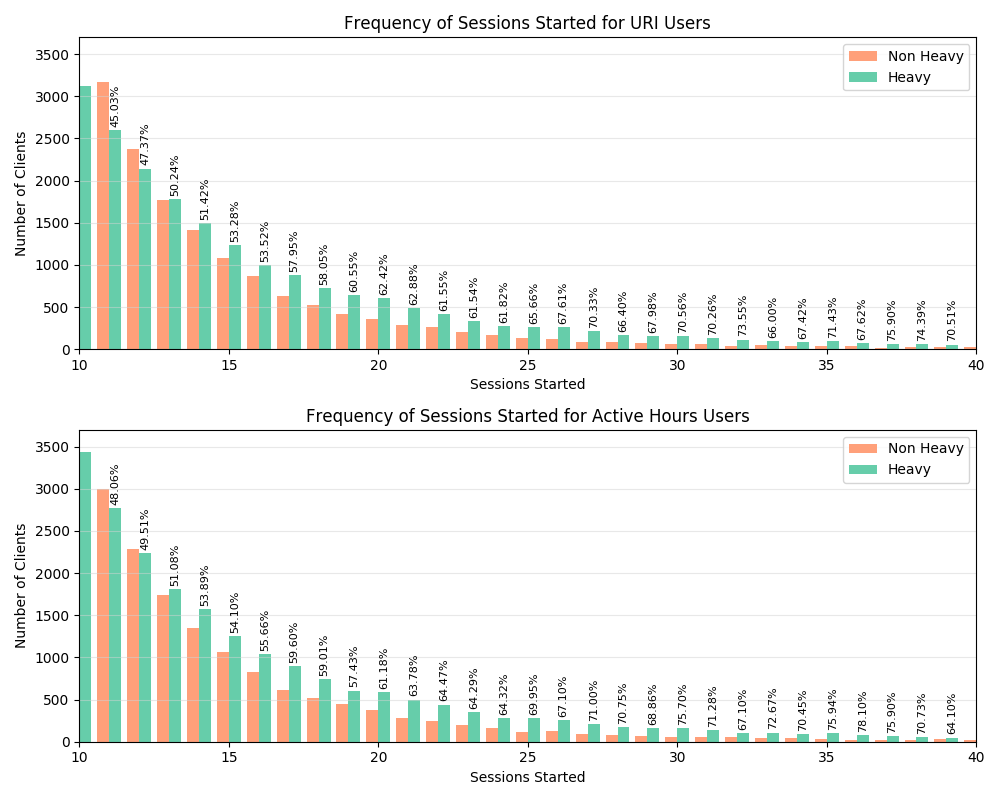

In [24]:
plot_three_heavy_bars(list_ss_plot_arrs, (10,8), 'Sessions Started', 'Frequency of Sessions Started', 40, 3700, xllim=11)

####Normalized Channel

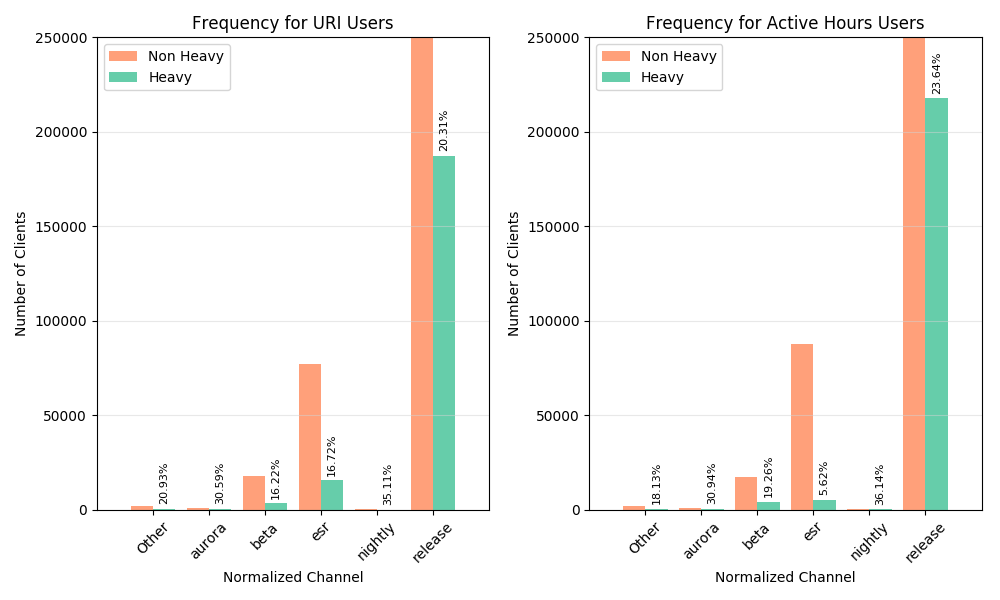

In [26]:
list_nc_plot_arrs = get_list_freq_arrays('normalized_channel')
plot_three_heavy_bars(list_nc_plot_arrs, (10,6), 'Normalized Channel', 'Frequency', 7, 250000,
                      conv_xaxis=True, rows=False)

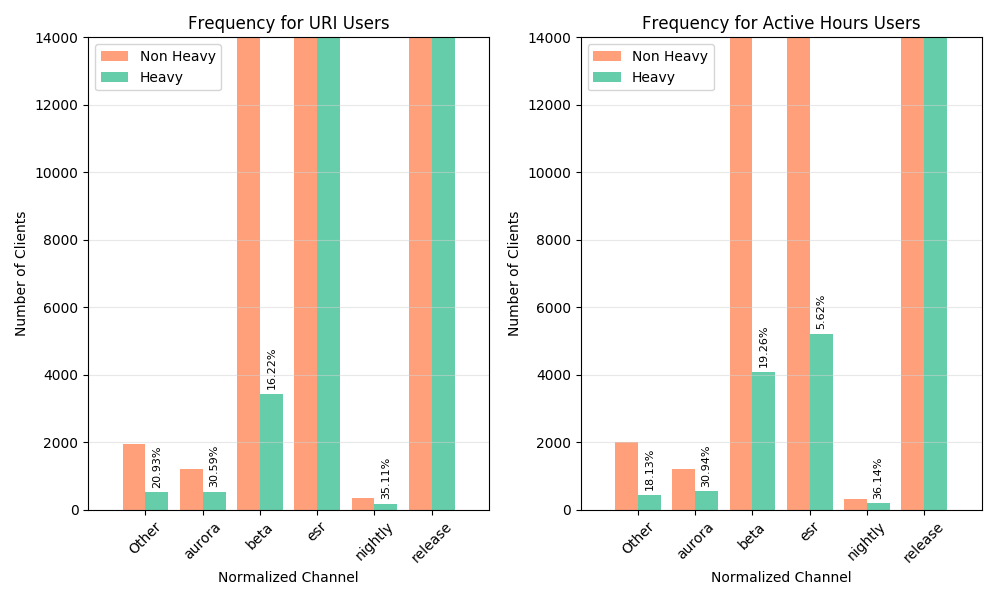

In [27]:
plot_three_heavy_bars(list_nc_plot_arrs, (10,6), 'Normalized Channel', 'Frequency', 7, 14000, conv_xaxis=True, rows=False)

####OS

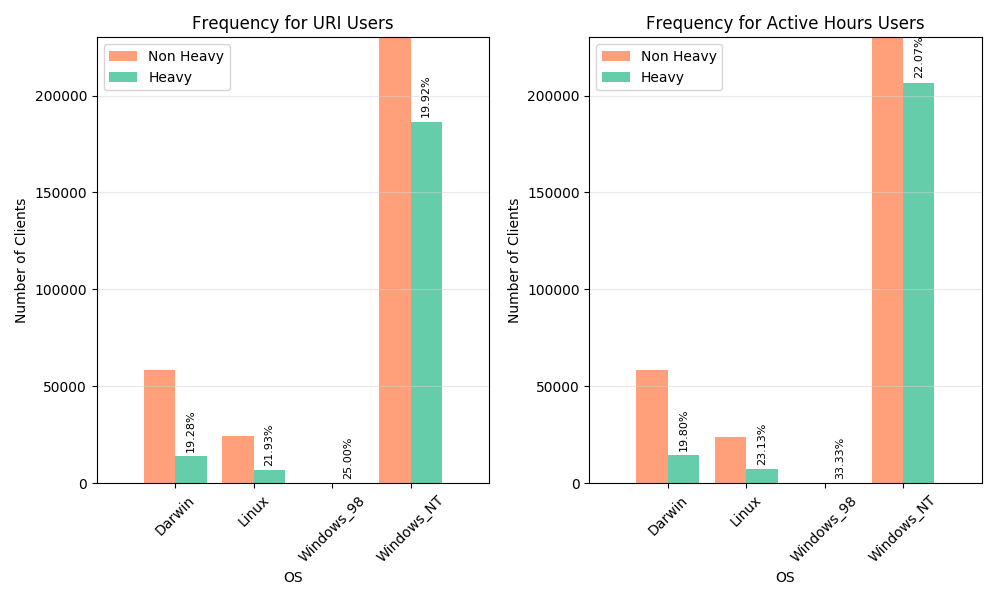

In [29]:
list_os_plot_arrs = get_list_freq_arrays('os')
plot_three_heavy_bars(list_os_plot_arrs, (10,6), 'OS', 'Frequency', 5, 230000, conv_xaxis=True, rows=False)

####Is Default Browser

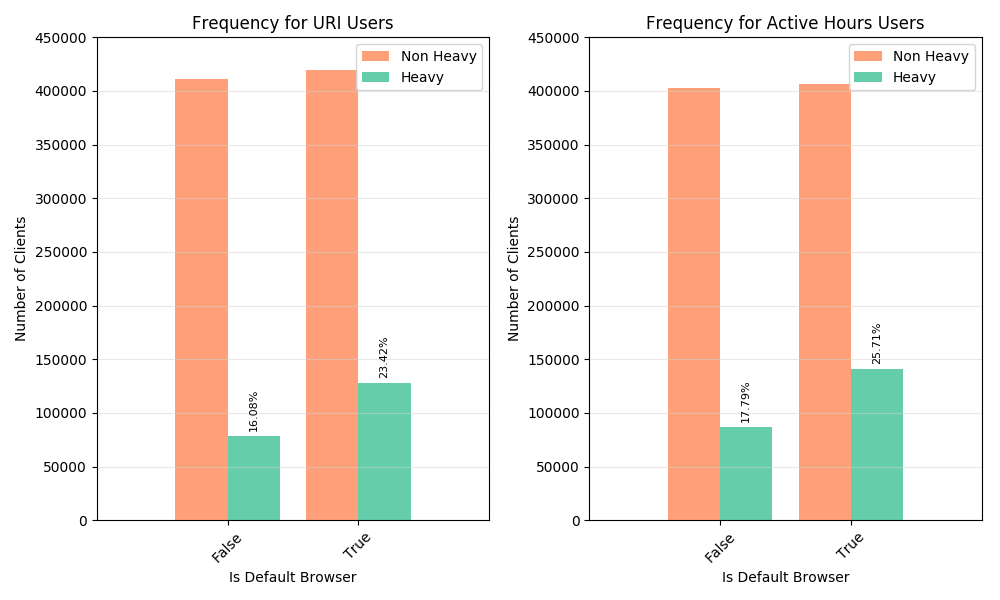

In [31]:
list_db_plot_arrs = get_list_freq_arrays('is_default_browser')
plot_three_heavy_bars(list_db_plot_arrs, (10,6), 'Is Default Browser', 'Frequency', 3, 450000, conv_xaxis=True, rows=False)

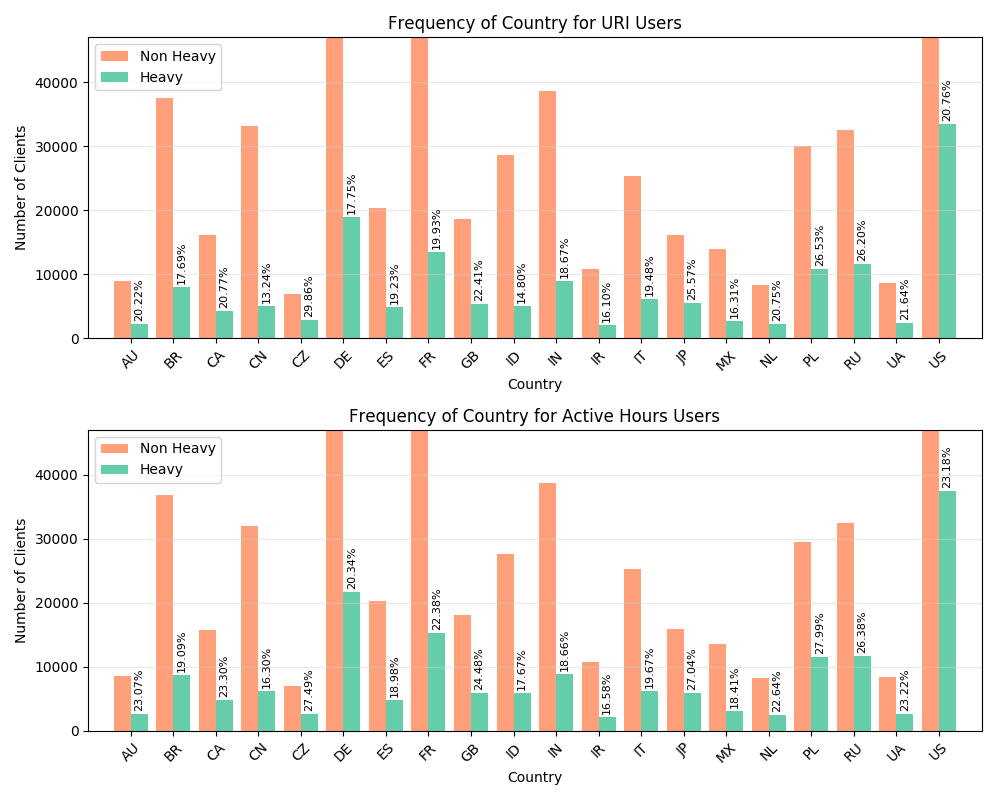

In [32]:
#country - 239
top_ctry = ['US', 'DE', 'FR', 'IN', 'BR', 'RU', 'PL', 'CN', 'ID', 'IT', 'ES', 'GB', 'JP', 'CA', 'MX', 'IR', 'AU', 'UA', 'NL', 'CZ']
ctr_wday = ms_wday.where(F.col('country').isin(top_ctry))

list_c_plot_arrs = get_list_freq_arrays('country', df=ctr_wday)
plot_three_heavy_bars(list_c_plot_arrs, (10,8), 'Country', 'Frequency of Country', 21, 47000, conv_xaxis=True)

####Locale

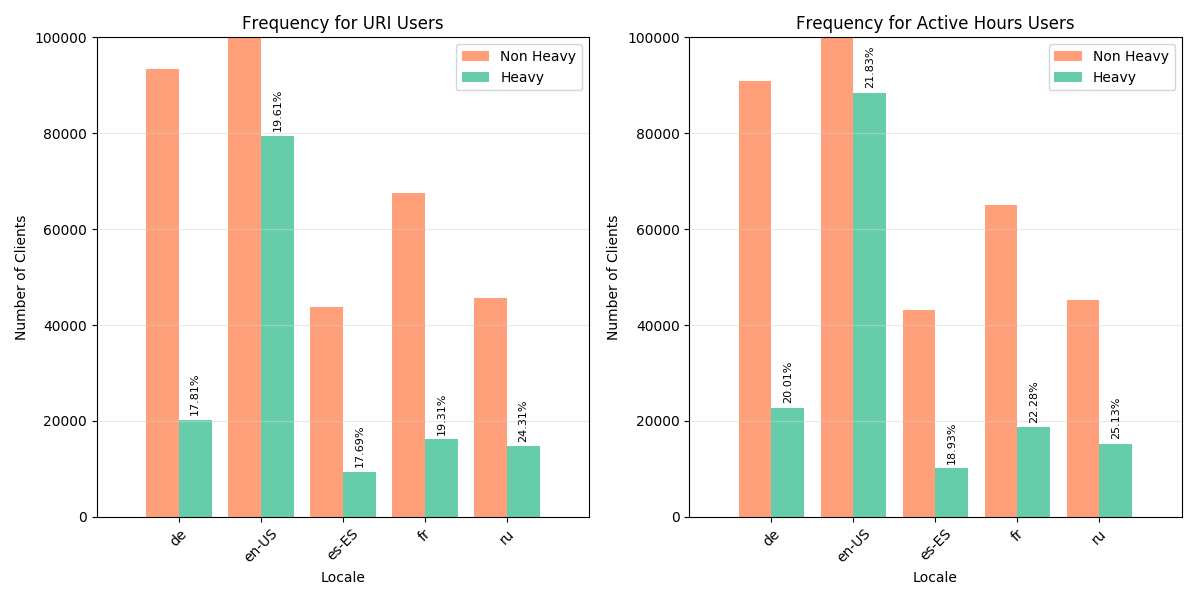

In [34]:
#locale - 93!
top_locale = ['en-US', 'de', 'fr', 'ru', 'es-ES']
locale_wday = ms_wday.where(F.col('locale').isin(top_locale))

list_tl_plot_arrs = get_list_freq_arrays('locale', df=locale_wday)
plot_three_heavy_bars(list_tl_plot_arrs, (12,6), 'Locale', 'Frequency', 6, 100000, conv_xaxis=True, rows=False)

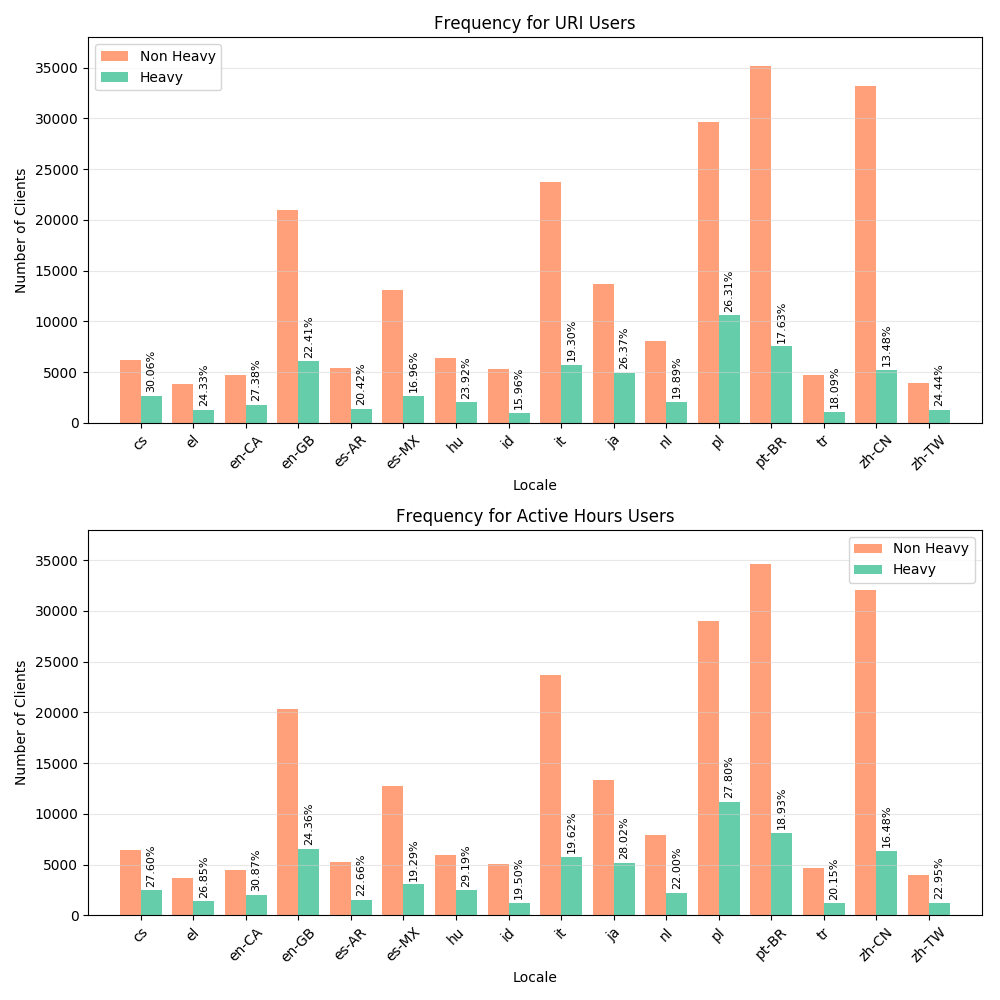

In [35]:
#locale - 93!
sec_locale = ['pt-BR', 'pl', 'zh-CN', 'it', 'en-GB', 'ja', 'es-MX', 'nl', 'cs', 'hu', 'es-AR', 'en-CA', 'id', 'tr', 'zh-TW', 'el']
slocale_wday = ms_wday.where(F.col('locale').isin(sec_locale))

list_sl_plot_arrs = get_list_freq_arrays('locale', df=slocale_wday)
plot_three_heavy_bars(list_sl_plot_arrs, (10,10), 'Locale', 'Frequency', 17, 38000, conv_xaxis=True)

####Default Search Engine

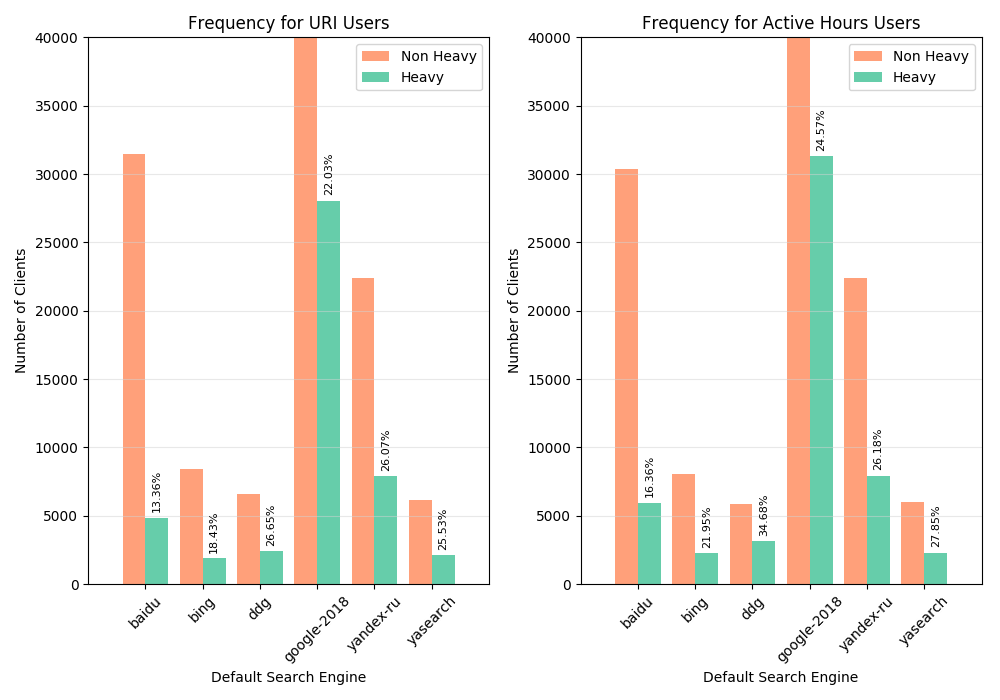

In [37]:
#default_search_engine - 1329
# too many for one plot - select a set of search engines, and pass in that df
# change get_freq_arrays to take an optional df
top_dse = ['google-2018', 'baidu', 'yandex-ru', 'bing', 'ddg', 'yasearch']
tdse_wday = ms_wday.where(F.col('default_search_engine').isin(top_dse))

list_tdse_plot_arrs = get_list_freq_arrays('default_search_engine', df=tdse_wday)
plot_three_heavy_bars(list_tdse_plot_arrs, (10,7), 'Default Search Engine', 'Frequency', 7, 40000, conv_xaxis=True, rows=False)

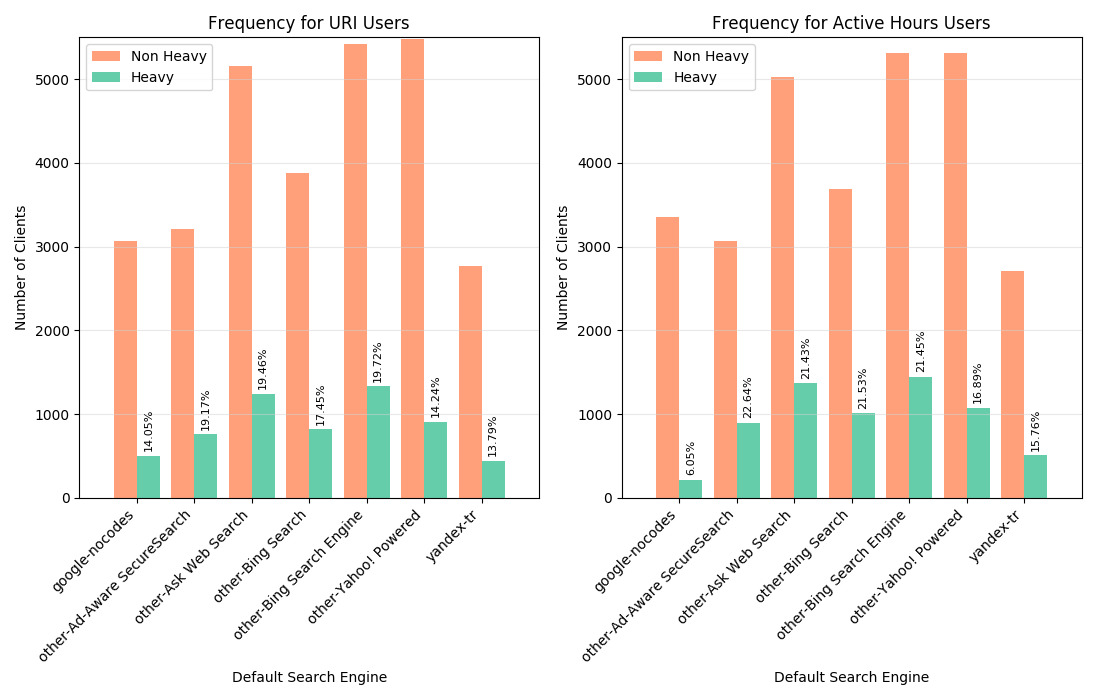

In [38]:
#default_search_engine - 1329
# too many for one plot - select a set of search engines, and pass in that df
# change get_freq_arrays to take an optional df
sec_dse = ['other-Bing Search Engine', 'other-Ask Web Search', 'other-Yahoo! Powered', 
           'other-Bing Search', 'other-Ad-Aware SecureSearch', 'google-nocodes', 'yandex-tr']
sdse_wday = ms_wday.where(F.col('default_search_engine').isin(sec_dse))

list_sdse_plot_arrs = get_list_freq_arrays('default_search_engine', df=sdse_wday)
plot_three_heavy_bars(list_sdse_plot_arrs, (11,7), 'Default Search Engine', 'Frequency', 8, 5500, 
                      conv_xaxis=True, xlabel_ra=True, rows=False)

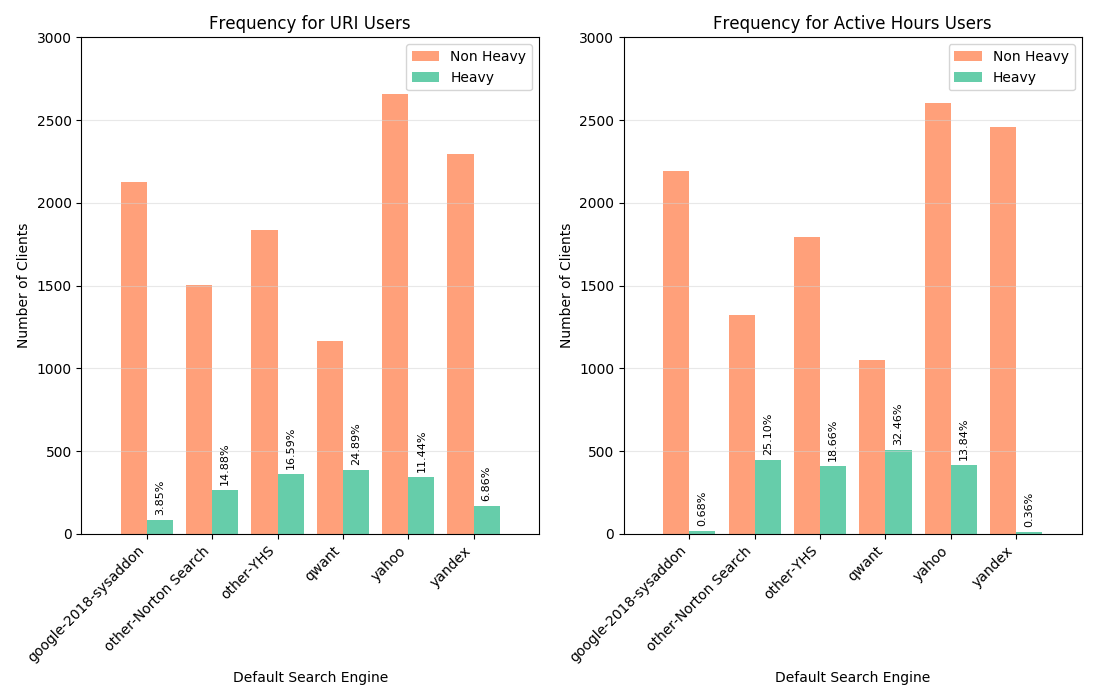

In [39]:
#default_search_engine - 1329
# too many for one plot - select a set of search engines, and pass in that df
# change get_freq_arrays to take an optional df
third_dse = ['yahoo', 'yandex', 'other-YHS', 'google-2018-sysaddon', 'other-Norton Search', 'qwant']
thdse_wday = ms_wday.where(F.col('default_search_engine').isin(third_dse))

list_thdse_plot_arrs = get_list_freq_arrays('default_search_engine', df=thdse_wday)
plot_three_heavy_bars(list_thdse_plot_arrs, (11,7), 'Default Search Engine', 'Frequency', 7, 3000, 
                      xllim=1, conv_xaxis=True, xlabel_ra=True, rows=False)